In [1]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
# Set paths
images_folder = '/kaggle/input/ham1000-segmentation-and-classification/images'
masks_folder = '/kaggle/input/ham1000-segmentation-and-classification/masks'
csv_file = '/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv'

groundtruth_df=pd.read_csv(csv_file)
# print(groundtruth_df.head())

# Extract image filenames and labels
images = groundtruth_df['image'].values
labels = groundtruth_df.drop(columns=['image']).values  # Drop image_id and keep the one-hot encoded labels

image_paths = []
mask_paths = []
all_labels = []

# Loop over the image filenames and generate paths
for image_filename, label in zip(images, labels):
    # Build image and mask paths
    image_path = os.path.join(images_folder, image_filename) + '.jpg'
    mask_path = os.path.join(masks_folder, image_filename) + '_segmentation.png'
    
    # Append to the lists
    image_paths.append(image_path)
    mask_paths.append(mask_path)
    all_labels.append(list(label))  # Store the one-hot encoded label

# Create a DataFrame with the image paths, mask paths, and labels
data = {
    'image_path': image_paths,
    'mask_path': mask_paths,
    'labels': all_labels
}

data_df = pd.DataFrame(data)

# Display the first few rows of the dataframe
print(data_df.head())
print(data_df['image_path'][100])
print(data_df['mask_path'][100])

                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0024406.jpg
/k

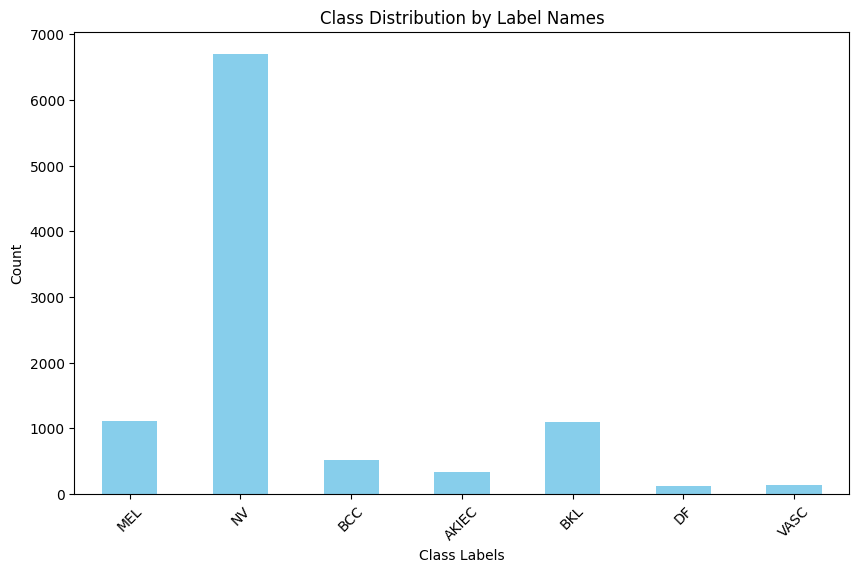

                                          image_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                           mask_path  \
0  /kaggle/input/ham1000-segmentation-and-classif...   
1  /kaggle/input/ham1000-segmentation-and-classif...   
2  /kaggle/input/ham1000-segmentation-and-classif...   
3  /kaggle/input/ham1000-segmentation-and-classif...   
4  /kaggle/input/ham1000-segmentation-and-classif...   

                                labels  class_label  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
2  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]            1  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]            0  
cl

In [3]:
class_labels_map = {
    0: 'MEL',
    1: 'NV',
    2: 'BCC',
    3: 'AKIEC',
    4: 'BKL',
    5: 'DF',
    6: 'VASC'
}

# Convert one-hot encoded labels to class indices
data_df['class_label'] = data_df['labels'].apply(lambda x: x.index(1))  # Convert one-hot to class indices

# Compute class distribution with label names
class_distribution = data_df['class_label'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(class_labels_map)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution by Label Names')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(data_df.head())
print(data_df['class_label'].value_counts())

In [4]:
def load_image(image_filename, image_dir, target_size=(224, 224)):
    image_path = os.path.join(image_dir, image_filename) + '.jpg'
    image = Image.open(image_path)
    image = image.resize(target_size)
    return np.array(image) / 255.0  # Normalize to [0, 1]

image = load_image(images[0], images_folder)

def load_masks(mask_paths, target_size=(224, 224)):
    masks = []
    for path in mask_paths:
        mask = Image.open(path).resize(target_size)
        masks.append(np.array(mask))  # No normalization for masks
    return np.array(masks)
    
print(image.shape)

(224, 224, 3)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    data_df[['image_path', 'mask_path']],  # Features
    data_df['class_label'],  # Labels
    test_size=0.3,
    stratify=data_df['class_label'],
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    data_df[['image_path', 'mask_path']],  # Features
    data_df['class_label'],  # Labels
    test_size=0.5,
    stratify=data_df['class_label'],
    random_state=42
)

print(y_test)
print(y_val)
print(y_train)

9679    0
5243    3
9169    1
6021    1
3676    4
       ..
4632    1
1315    1
7277    1
9920    1
301     1
Name: class_label, Length: 5007, dtype: int64
630     1
8534    0
3947    1
2545    1
8998    0
       ..
5480    1
746     1
1694    1
9025    1
3296    1
Name: class_label, Length: 5008, dtype: int64
7107    2
3367    0
8698    0
4288    1
6172    1
       ..
6815    1
3534    1
5803    1
1014    1
4986    1
Name: class_label, Length: 7010, dtype: int64


# CNN Classification Task

In [6]:
class HAM10000Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths.iloc[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels.iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
# Dataset and DataLoader
train_dataset = HAM10000Dataset(X_train['image_path'], y_train, transform=train_transform)
val_dataset = HAM10000Dataset(X_val['image_path'], y_val, transform=test_transform)
test_dataset = HAM10000Dataset(X_test['image_path'], y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)  # Use ResNet18 as a base model
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify the output layer

    def forward(self, x):
        return self.model(x)

model = SimpleCNN(num_classes=len(class_labels_map))
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Model has 11,180,103 parameters


Epoch 1/10, Loss: 0.3057, Train Accuracy: 0.8880, Val Accuracy: 0.8604, Val Loss: 0.4060
Epoch 2/10, Loss: 0.2666, Train Accuracy: 0.9016, Val Accuracy: 0.8742, Val Loss: 0.3812
Epoch 3/10, Loss: 0.2155, Train Accuracy: 0.9208, Val Accuracy: 0.8914, Val Loss: 0.3260
Epoch 4/10, Loss: 0.1869, Train Accuracy: 0.9344, Val Accuracy: 0.8834, Val Loss: 0.3903
Epoch 5/10, Loss: 0.1548, Train Accuracy: 0.9474, Val Accuracy: 0.9065, Val Loss: 0.3174
Epoch 6/10, Loss: 0.1351, Train Accuracy: 0.9515, Val Accuracy: 0.8974, Val Loss: 0.3131
Epoch 7/10, Loss: 0.1307, Train Accuracy: 0.9538, Val Accuracy: 0.8992, Val Loss: 0.3583
Epoch 8/10, Loss: 0.1114, Train Accuracy: 0.9613, Val Accuracy: 0.9109, Val Loss: 0.3100
Epoch 9/10, Loss: 0.1099, Train Accuracy: 0.9622, Val Accuracy: 0.9163, Val Loss: 0.2970
Epoch 10/10, Loss: 0.0745, Train Accuracy: 0.9735, Val Accuracy: 0.9054, Val Loss: 0.3725
Best Validation Accuracy: 0.9163


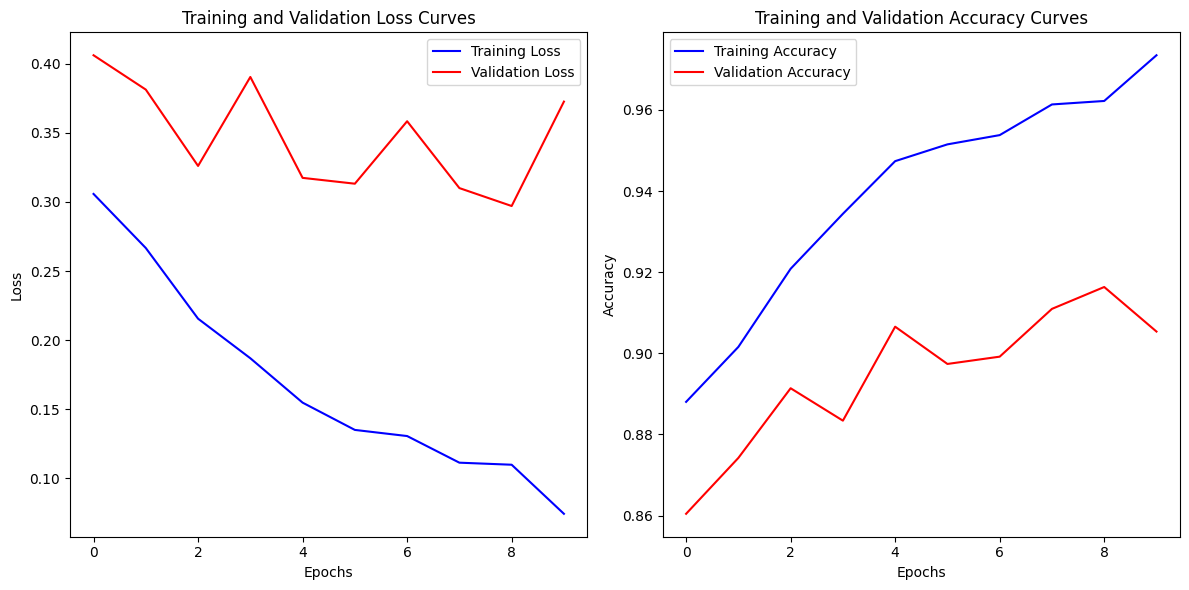

In [14]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    val_losses = []  # To track validation losses
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train  # Training accuracy

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0  # To accumulate validation loss
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Validation loss
                val_loss += loss.item() * images.size(0)
                
                # Compute validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val  # Validation accuracy

        # Store values for plotting
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)  # Store validation loss
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print training and validation accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
        
        best_acc = max(best_acc, val_acc)
    
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    # Plotting the Loss and Accuracy Curves
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()

    # Plot Training and Validation Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, num_epochs=10)

Test Accuracy: 0.9814


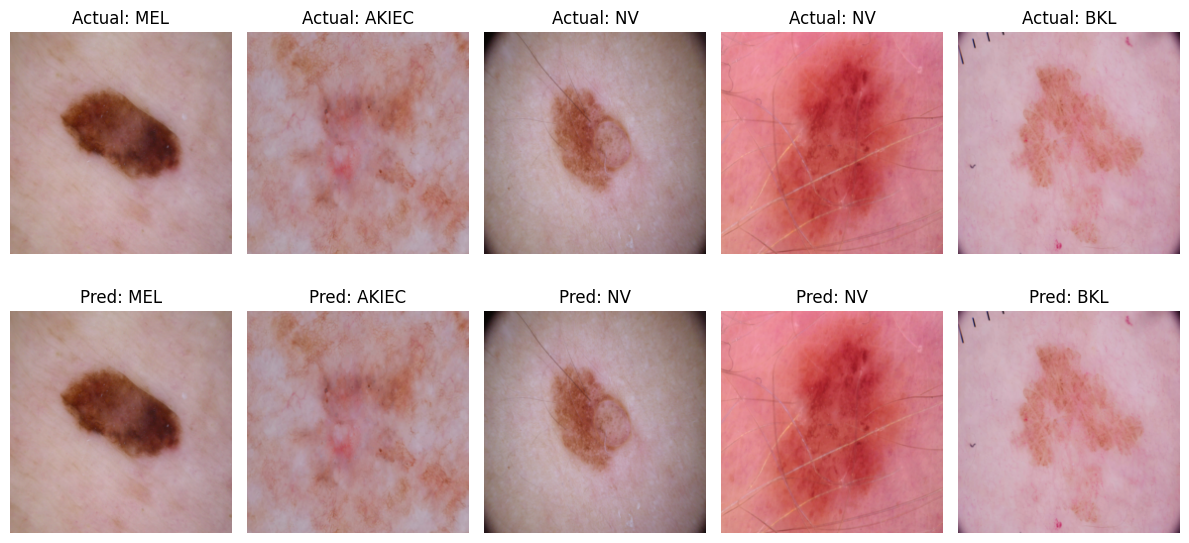

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        # Loop through the test set
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Track predictions and actual labels
            predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
            actuals.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    

def display_sample_images(test_loader, predictions, actuals, num_images=5):
    # Get a batch of test images
    images, labels = next(iter(test_loader))
    
    # Convert images to numpy arrays for displaying
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert to HWC format
    
    # Plot random images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        img = images[i]
        plt.imshow(np.clip(img, 0, 1))  # Ensure values are between 0 and 1 for display
        plt.title(f"Actual: {class_labels_map[actuals[i]]}")
        plt.axis('off')
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Pred: {class_labels_map[predictions[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


test_model(model, test_loader)
display_sample_images(test_loader, predictions, actuals)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models, transforms
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Define the classification model (Fine-tuning ResNet50)
# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ClassificationModel, self).__init__()
#         self.resnet = models.resnet50(pretrained=True)
#         # Modify the final fully connected layer to output num_classes
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.resnet(x)

# # Initialize the model
# model = ClassificationModel(num_classes=7)

# # Display the number of parameters in the model
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters: {total_params / 1e6} million")

# # Define data transforms
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Assuming the datasets are already created as DataLoader objects
# # Example:
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Set up optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()

# # Train the model (simplified training loop)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# def train_epoch(model, data_loader, optimizer, criterion):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0
    
#     for images, labels in data_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Calculate accuracy
#         _, preds = torch.max(outputs, 1)
#         correct_predictions += torch.sum(preds == labels)
#         total_predictions += labels.size(0)

#     epoch_loss = running_loss / len(data_loader)
#     epoch_accuracy = correct_predictions.double() / total_predictions
#     return epoch_loss, epoch_accuracy

# # Example training loop:
# # for epoch in range(num_epochs):
# #     train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion)
# #     print(f"Epoch {epoch + 1}, Loss: {train_loss}, Accuracy: {train_accuracy}")

# # Evaluate the model on the test set
# def evaluate(model, data_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     # Compute classification metrics
#     accuracy = accuracy_score(all_labels, all_preds)
#     print(f"Accuracy: {accuracy}")

#     print("Classification Report:")
#     print(classification_report(all_labels, all_preds))

#     # Confusion Matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_map.values(), yticklabels=class_labels_map.values())
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()

# # Example usage:
# # evaluate(model, test_loader)
# import torch.nn.functional as F
# from torch import nn

# class UNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super(UNet, self).__init__()

#         # Encoder
#         self.enc1 = self.conv_block(in_channels, 64)
#         self.enc2 = self.conv_block(64, 128)
#         self.enc3 = self.conv_block(128, 256)
#         self.enc4 = self.conv_block(256, 512)
#         self.enc5 = self.conv_block(512, 1024)

#         # Decoder
#         self.dec4 = self.upconv_block(1024, 512)
#         self.dec3 = self.upconv_block(512, 256)
#         self.dec2 = self.upconv_block(256, 128)
#         self.dec1 = self.upconv_block(128, 64)

#         self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def upconv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         enc1 = self.enc1(x)
#         enc2 = self.enc2(F.max_pool2d(enc1, 2))
#         enc3 = self.enc3(F.max_pool2d(enc2, 2))
#         enc4 = self.enc4(F.max_pool2d(enc3, 2))
#         enc5 = self.enc5(F.max_pool2d(enc4, 2))

#         dec4 = self.dec4(enc5)
#         dec3 = self.dec3(dec4 + enc4)
#         dec2 = self.dec2(dec3 + enc3)
#         dec1 = self.dec1(dec2 + enc2)

#         output = self.final_conv(dec1 + enc1)
#         return output

# # Instantiate U-Net model
# segmentation_model = UNet(in_channels=3, out_channels=1)  # Output is a single channel mask
# class CombinedModel(nn.Module):
#     def __init__(self, num_classes=7):
#         super(CombinedModel, self).__init__()
#         self.base_model = models.resnet50(pretrained=True)  # Pre-trained backbone

#         # Classification head
#         self.classification_head = nn.Linear(self.base_model.fc.in_features, num_classes)

#         # Segmentation head
#         self.segmentation_head = UNet(in_channels=3, out_channels=1)

#     def forward(self, x):
#         features = self.base_model(x)  # Extract features from the base model
        
#         # Classification output
#         class_output = self.classification_head(features)
        
#         # Segmentation output (using features)
#         seg_output = self.segmentation_head(x)
        
#         return class_output, seg_output
